# Adaboost

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
class MyAdaboost():
    def __init__(self, n_estimators=10, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Initialise weights to be equal
        N = X.shape[0]
        data_weights = np.ones(N)
        
        self.alpha_list = []
        self.final_tree_list = []
        
        # Main training loop
        for i in range(self.n_estimators):

            # Calculate and store the lowest error rate of DTs
            tree = DecisionTreeClassifier(max_depth=2).fit(X, y, sample_weight=data_weights)

            tree_preds = tree.predict(X)
            tree_error = 1 - accuracy_score(y, tree_preds, sample_weight=data_weights)
            
            # Calculate the voting power 
            alpha = 0.5 * np.log((1-tree_error)/tree_error)
            
            # Add alpha and decision tree model to lists
            self.alpha_list.append(alpha)
            self.final_tree_list.append(tree)
            
            # Update weights for next iteration
            correct_weight = 1/(2*(1 - tree_error)) * data_weights 
            incorrect_weight = 1/(2 * tree_error) * data_weights
            data_weights = np.where(tree_preds == y, correct_weight, incorrect_weight)
    
        return self
        
    def predict(self, X):
        
        # Iterate over all trees in ensemble
        preds_list = []
        for i in range(len(self.final_tree_list)):
            tree_pred_i = (self.final_tree_list[i].predict(X) - 0.5) * 2 # normalize to range [-1,1]
            weighted_tree_pred_i = self.alpha_list[i] * tree_pred_i
            preds_list.append(weighted_tree_pred_i)
        
        # Sum predictions
        final_pred = np.sum(preds_list, axis=0)

        # Get the sign of the sum and convert to prediction 0 or 1
        return np.sign(final_pred).clip(min=0)

## - Parameter: Ensemble Size

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

np.random.seed(0)

In [4]:
# Generate some synthetic data
X, y = make_classification(n_samples=1000, n_features=30, n_informative=15)

b = np.arange(1, 11)
accuracy_list = []

repeats = 5
all_results = np.zeros((len(b),repeats))
for idx_b in range(len(b)):
    n_estimators = b[idx_b]
    for idx_rep in range(repeats):
        model = MyAdaboost(n_estimators=n_estimators)
        model.fit(X,y)
        all_results[idx_b, idx_rep] = accuracy_score(y, model.predict(X))

In [5]:
mean_accuracy = np.mean(all_results, axis=1)
std_accuracy = np.std(all_results, axis=1)

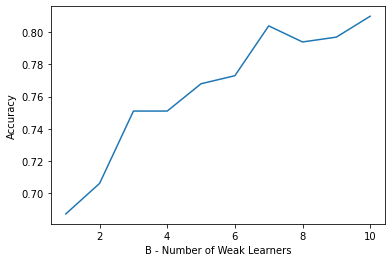

In [6]:
plt.figure()
plt.plot(b, mean_accuracy)
plt.fill_between(b, mean_accuracy + std_accuracy, mean_accuracy - std_accuracy, facecolor='lightblue')

plt.ylabel('Accuracy')
plt.xlabel('B - Number of Weak Learners')
plt.savefig('plot.png')

## - Does Adaboost overfit?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(0)

In [8]:
# Generate some synthetic data
X, y = make_classification(n_samples=1000, n_features=30, n_informative=15)

b = np.arange(1, 40)

repeats = 5

train_accuracy_all = np.zeros((len(b), repeats))
valid_accuracy_all = np.zeros((len(b), repeats))

for idx_b in range(len(b)):
    n_estimators = b[idx_b]

    for idx_rep in range(repeats):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        model = MyAdaboost(n_estimators=n_estimators)
        model.fit(X_train,y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train))
        train_accuracy_all[idx_b, idx_rep] = train_acc

        valid_acc = accuracy_score(y_test, model.predict(X_test))
        valid_accuracy_all[idx_b, idx_rep] = valid_acc

In [9]:
mean_train_accuracy = np.mean(train_accuracy_all, axis=1)
std_train_accuracy = np.std(train_accuracy_all, axis=1)

mean_valid_accuracy = np.mean(valid_accuracy_all, axis=1)
std_valid_accuracy = np.std(valid_accuracy_all, axis=1)

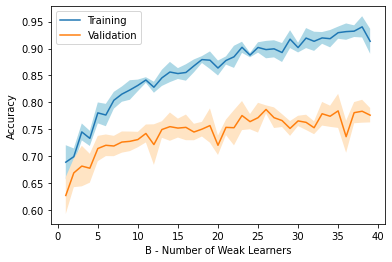

In [10]:
plt.plot(b, mean_train_accuracy, label='Training')
plt.fill_between(b, mean_train_accuracy + std_train_accuracy, mean_train_accuracy - std_train_accuracy, facecolor='lightblue')

plt.plot(b, mean_valid_accuracy, label='Validation')
plt.fill_between(b, mean_valid_accuracy + std_valid_accuracy, mean_valid_accuracy - std_valid_accuracy, facecolor='bisque')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('B - Number of Weak Learners')
plt.show()

***

# Gradient Boosting

## - Regression

In [14]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

In [15]:
class GradientBoostRegressor:
    
    def __init__(self, n_estimators, random_state):
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):

        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.alpha = 1
        self.trees = []

        # use the mean as F_0
        self.mean = np.mean(y, axis=0)
        y_pred = np.full(np.shape(y), self.mean)
        
        for i in range(self.n_estimators):
            g = -y + y_pred
            tree = DecisionTreeRegressor(max_depth=1).fit(X, g)
            res = tree.predict(X).reshape(-1, 1)
            y_pred = y_pred - self.alpha * res
            self.trees.append(tree)

    def predict(self, X):
        pred = np.full((np.shape(X)[0], 1), self.mean)
        for tree in self.trees:
            res = tree.predict(X).reshape(-1, 1)
            pred = pred - self.alpha * res
        return pred

In [16]:
# Lets test our implementation!
car_prices = pd.read_csv('data/car_price_w10.csv')

X = car_prices['Odometer'].values.reshape(-1, 1)
y = car_prices['Price'].values.reshape(-1, 1)

gbmodel = GradientBoostRegressor(n_estimators=20, random_state=0)
gbmodel.fit(X, y)

print(gbmodel.predict(X)[:5].T.round(4))
print(y[:5].T)

[[15.8491 15.3671 15.3671 17.0906 16.9769]]
[[16.  15.2 15.  17.4 17.4]]


## - Classification

In [19]:
import numpy as np
import pandas as pd
from random import shuffle
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor

In [20]:
# Iris dataset
iris = datasets.load_iris()
data = iris.data
target = iris.target

In [21]:
# randomly select 12 samples to train on 
np.random.seed(0)

n = 12
randidx = np.random.randint(0, len(target), n) # n randomly generated integers in from 0 to len(data)
X = data[randidx, :]
y = target[randidx]

In [22]:
# why we get_dummies of the target?
y = pd.get_dummies(y)
y = y.values
y

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [43]:
# Softmax function
def FtoP(F):
    expF = np.exp(F)
    a = expF.sum(axis=1)
    P = expF / a[:,None]
    return P

***

***

In [44]:
F = np.zeros((n,3))
P = FtoP(F)
FtoP(np.array([[1, 2, 3]]))

array([[0.09003057, 0.24472847, 0.66524096]])

In [45]:
test = np.exp(np.array([[5, 6, 7], [1, 2, 3]])).sum(axis=1)
test[:, None]

array([[1648.47511102],
       [  30.19287485]])

In [46]:
test = np.exp(np.array([[5, 6, 7], [1, 2, 3]])).sum(axis=1)
test.reshape(-1, 1)

array([[1648.47511102],
       [  30.19287485]])

***

***

In [47]:
# set the number of iterations T = 3, i.e. number of estimators 
T = 3

# set the learning rate rho (for simplicity, we set it to 1)
rho = 1

# initalization
F = np.zeros((n,3))
P = FtoP(F)

In [48]:
# model placeholders for each class
baseH0 = []
baseH1 = []
baseH2 = []

for iteration in range(T):
    # update the negative gradient based on current P
    NegG = y - P
    
    # fit a decision tree for class 0
    tree = DecisionTreeRegressor(max_depth=1)
    h0 = tree.fit(X, NegG[:, 0])
    baseH0.append(h0)

    # fit a decision tree for class 1
    tree = DecisionTreeRegressor(max_depth=1)
    h1 = tree.fit(X, NegG[:, 1])
    baseH1.append(h1)
    
    # fit a decision tree for class 2
    tree = DecisionTreeRegressor(max_depth=1)
    h2 = tree.fit(X, NegG[:, 2])
    baseH2.append(h2)
    
    # update model prediction F by adding this model
    F[:, 0] = F[:, 0] + rho * h0.predict(X)
    F[:, 1] = F[:, 1] + rho * h1.predict(X)
    F[:, 2] = F[:, 2] + rho * h2.predict(X)
    
    # calculate the probability prediction P based on F
    P = FtoP(F)

In [49]:
# randomly extract 4 samples as test data
np.random.seed(1)
randidx = np.random.randint(0, len(target), 4) 
X_test = data[randidx, :]
y_test = target[randidx]
y_test

array([0, 2, 1, 2])

In [50]:
# start F with zero
F0 = 0.0
F1 = 0.0
F2 = 0.0

for iteration in range(T):
    F0 = F0 + baseH0[iteration].predict(X_test)
    F1 = F1 + baseH1[iteration].predict(X_test)
    F2 = F2 + baseH2[iteration].predict(X_test)

F = np.vstack((F0,F1,F2))
F = F.T
F

array([[ 1.39585062, -0.27402579, -0.7350372 ],
       [-0.73095553, -0.24012821,  1.51563604],
       [-0.73095553,  0.82983126, -0.7350372 ],
       [-0.73095553, -0.24012821,  1.51563604]])

In [51]:
# get predicted probabilities
P = FtoP(F)
P

array([[0.76510967, 0.14404745, 0.09084287],
       [0.08271901, 0.13513533, 0.78214566],
       [0.14796197, 0.70467877, 0.14735926],
       [0.08271901, 0.13513533, 0.78214566]])

In [52]:
# prediction
y_pred = np.argmax(P, axis = 1)
y_pred

array([0, 2, 1, 2], dtype=int64)

***

# XGBoost
https://xgboost.readthedocs.io/en/latest/parameter.html

## - XGBoost classification on Diabetes

In [56]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [57]:
dataset = pd.read_csv('data/pima-indians-diabetes_w10.csv', header= None)
dataset.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [58]:
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [60]:
model = XGBClassifier().fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [61]:
y_pred = model.predict(X_test)

In [62]:
# classification report of the prediction
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       170
           1       0.65      0.58      0.62        84

    accuracy                           0.76       254
   macro avg       0.73      0.72      0.72       254
weighted avg       0.75      0.76      0.76       254



## - XGBoost regression on Boston Housing
http://lib.stat.cmu.edu/datasets/boston

In [64]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston

In [65]:
# load dataset 
boston = load_boston()
X = boston['data']
y = boston['target']

X.shape

(506, 13)

In [66]:
xgb_reg = XGBRegressor()

reg = GridSearchCV(xgb_reg, {'eta': [0.1, 0.5, 1.0],
                             'n_estimators': [50,100,200],
                             'max_depth': [2,4,6]})
reg.fit(X,y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                   

In [67]:
print(reg.best_score_)
print()
print(reg.best_params_)

0.6697440842543696

{'eta': 0.1, 'max_depth': 2, 'n_estimators': 100}
